In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,r2_score, classification_report, matthews_corrcoef, confusion_matrix

from keras.models import Sequential
from tensorflow.keras import regularizers
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pickle

In [2]:
df = pd.read_csv('final.txt')
df = df.rename(columns={'pdockq1': 'pdockq2', 'pdockq2': 'pdockq1'})
selected_features = ['IntraclashesGroup1', 'IntraclashesGroup2', 'Interaction Energy',
       'Backbone Hbond', 'Sidechain Hbond', 'Van der Waals', 'Electrostatics',
       'Solvation Polar', 'Solvation Hydrophobic', 'Van der Waals clashes',
       'entropy sidechain', 'entropy mainchain', 'ptm_iptm',
       'pdockq2', 'pdockq1', 'backbone clash',
       'Interface Residues', 'pred_contact', 'Interface Residues Clashing', 'electrostatic kon',
       'Interface Residues BB Clashing', 'Interface Residues VdW Clashing','obs_contact'] #'Number of Residues'

In [3]:
# Make it binary by setting a threshold and split training and test
binary_obs_contact = np.where(df['obs_contact'] > 0, 1, 0)  # change here if necessary

pos_cor_features=[]
neg_cor_features=[]

### find the features with negative correlation
for feature in selected_features:
    #print(feature, np.corrcoef(binary_obs_contact,df[feature])[0][1])
    if np.corrcoef(binary_obs_contact,df[feature])[0][1] > 0:
        pos_cor_features.append(feature)
    else:
        neg_cor_features.append(feature)
#print (pos_cor_features)
#print (neg_cor_features)

In [4]:
def just_minmaxscale(df, feature):
    ### just scale within each structure
    #if feature in neg_cor_features: df[feature] = df[feature] * (-1)
    minimum = df[feature].min()
    maximum = df[feature].max()
    SD = df[feature].std()
    Mean = df[feature].mean()
    n = len(set(df['chain1']).union(set(df['chain2'])))
    if maximum==minimum:
        df[feature] = df[feature]-df[feature]+0.5
    else:
        df[feature] = (df[feature]-minimum)/(maximum-minimum)
    return df

def ranked_minmaxscale(df, feature):
    ### just scale within each structure
    #if feature in neg_cor_features: df[feature] = df[feature] * (-1)
    df[feature] = df[feature].rank()
    minimum = df[feature].min()
    maximum = df[feature].max()
    SD = df[feature].std()
    Mean = df[feature].mean()
    n = len(set(df['chain1']).union(set(df['chain2'])))
    if maximum==minimum:
        df[feature] = df[feature]
    else:
        df[feature] = (df[feature]-minimum)/(maximum-minimum)
    return df

def ranked_normalscale(df, feature):
    ### just scale within each structure
    #if feature in neg_cor_features: df[feature] = df[feature] * (-1)
    df[feature] = df[feature].rank()
    minimum = df[feature].min()
    maximum = df[feature].max()
    SD = df[feature].std()
    Mean = df[feature].mean()
    n = len(set(df['chain1']).union(set(df['chain2'])))
    if maximum==minimum:
        df[feature] = df[feature]
    else:
        df[feature] = (df[feature]-Mean)/SD
    return df

def just_normalscale(df, feature):
    ### just scale within each structure
    #if feature in neg_cor_features: df[feature] = df[feature] * (-1)
    minimum = df[feature].min()
    maximum = df[feature].max()
    SD = df[feature].std()
    Mean = df[feature].mean()
    n = len(set(df['chain1']).union(set(df['chain2'])))
    if maximum==minimum:
        df[feature] = df[feature]
    else:
        df[feature] = (df[feature]-Mean)/SD
    return df

In [5]:
# prepare the modified Data
df2= pd.DataFrame()
df2['pair']=df['pair']
df2['pdb_id'] = df2['pair'].apply(lambda x: x.split('_')[0])
df2['chain1'] = df2['pair'].apply(lambda x: x.split('_')[1])
df2['chain2'] = df2['pair'].apply(lambda x: x.split('_')[3])

df2[selected_features]=df[selected_features]

for feature in selected_features:
    if feature in ['pred_contact','pdockq2', 'pdockq1','ptm_iptm']:
        df2 = df2.groupby('pdb_id').apply(lambda x: ranked_minmaxscale(x, feature))
    elif feature in ['obs_contact']:
        df2 = df2.groupby('pdb_id').apply(lambda x: just_minmaxscale(x, feature))
    else:
        df2 = df2.groupby('pdb_id').apply(lambda x: ranked_minmaxscale(x, feature))

Text(0.5, 0, 'Contact Residues Count (MinMax Scale)')

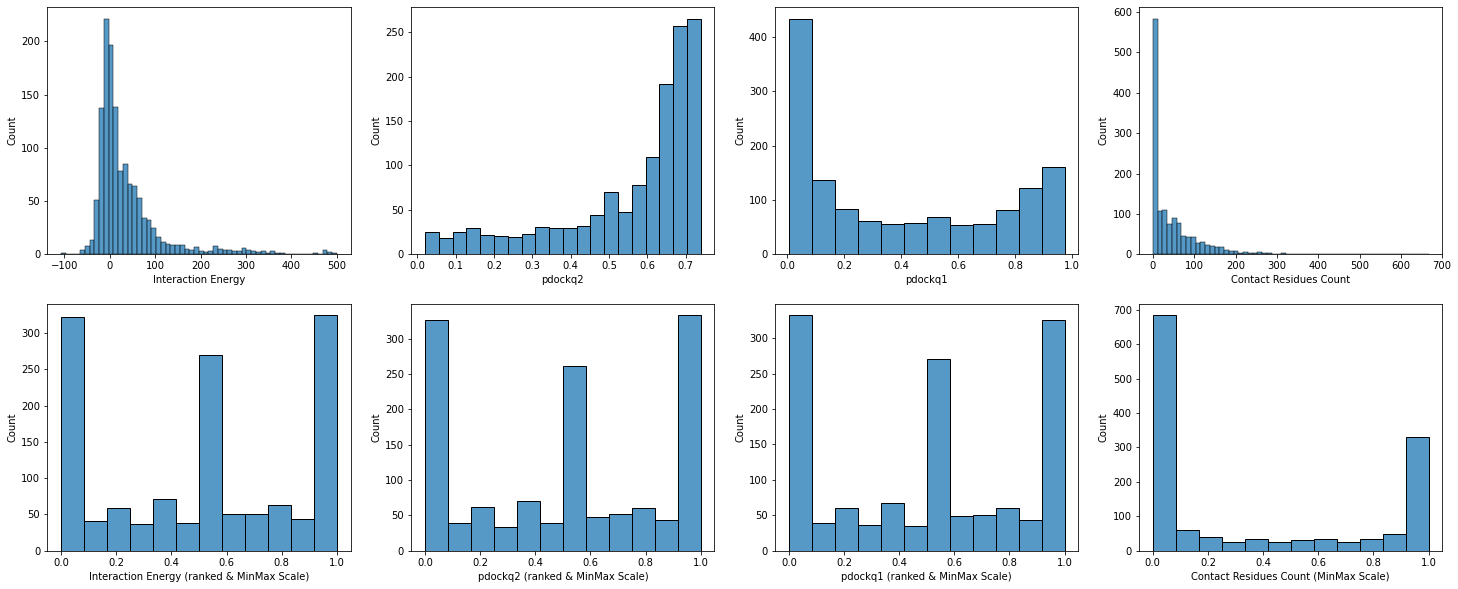

In [6]:
#df2[df2.pair.str.contains('5LE5')].sort_values(by=['pair'])[['pair','pred_contact','pdockq2','Interaction Energy','obs_contact']]
fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(25,10))
sns.histplot(df['Interaction Energy'],ax=axes[0,0], binrange=(-107,500))
sns.histplot(df2['Interaction Energy'],ax=axes[1,0])
axes[1, 0].set_xlabel('Interaction Energy (ranked & MinMax Scale)')
sns.histplot(df.pdockq2,ax=axes[0,1])
sns.histplot(df2.pdockq2,ax=axes[1,1])
axes[1, 1].set_xlabel('pdockq2 (ranked & MinMax Scale)')
sns.histplot(df.pdockq1,ax=axes[0,2])
sns.histplot(df2.pdockq1,ax=axes[1,2])
axes[1, 2].set_xlabel('pdockq1 (ranked & MinMax Scale)')
sns.histplot(df.obs_contact,ax=axes[0,3])
axes[0, 3].set_xlabel('Contact Residues Count')
sns.histplot(df2.obs_contact,ax=axes[1,3])
axes[1, 3].set_xlabel('Contact Residues Count (MinMax Scale)')
#df2.columns

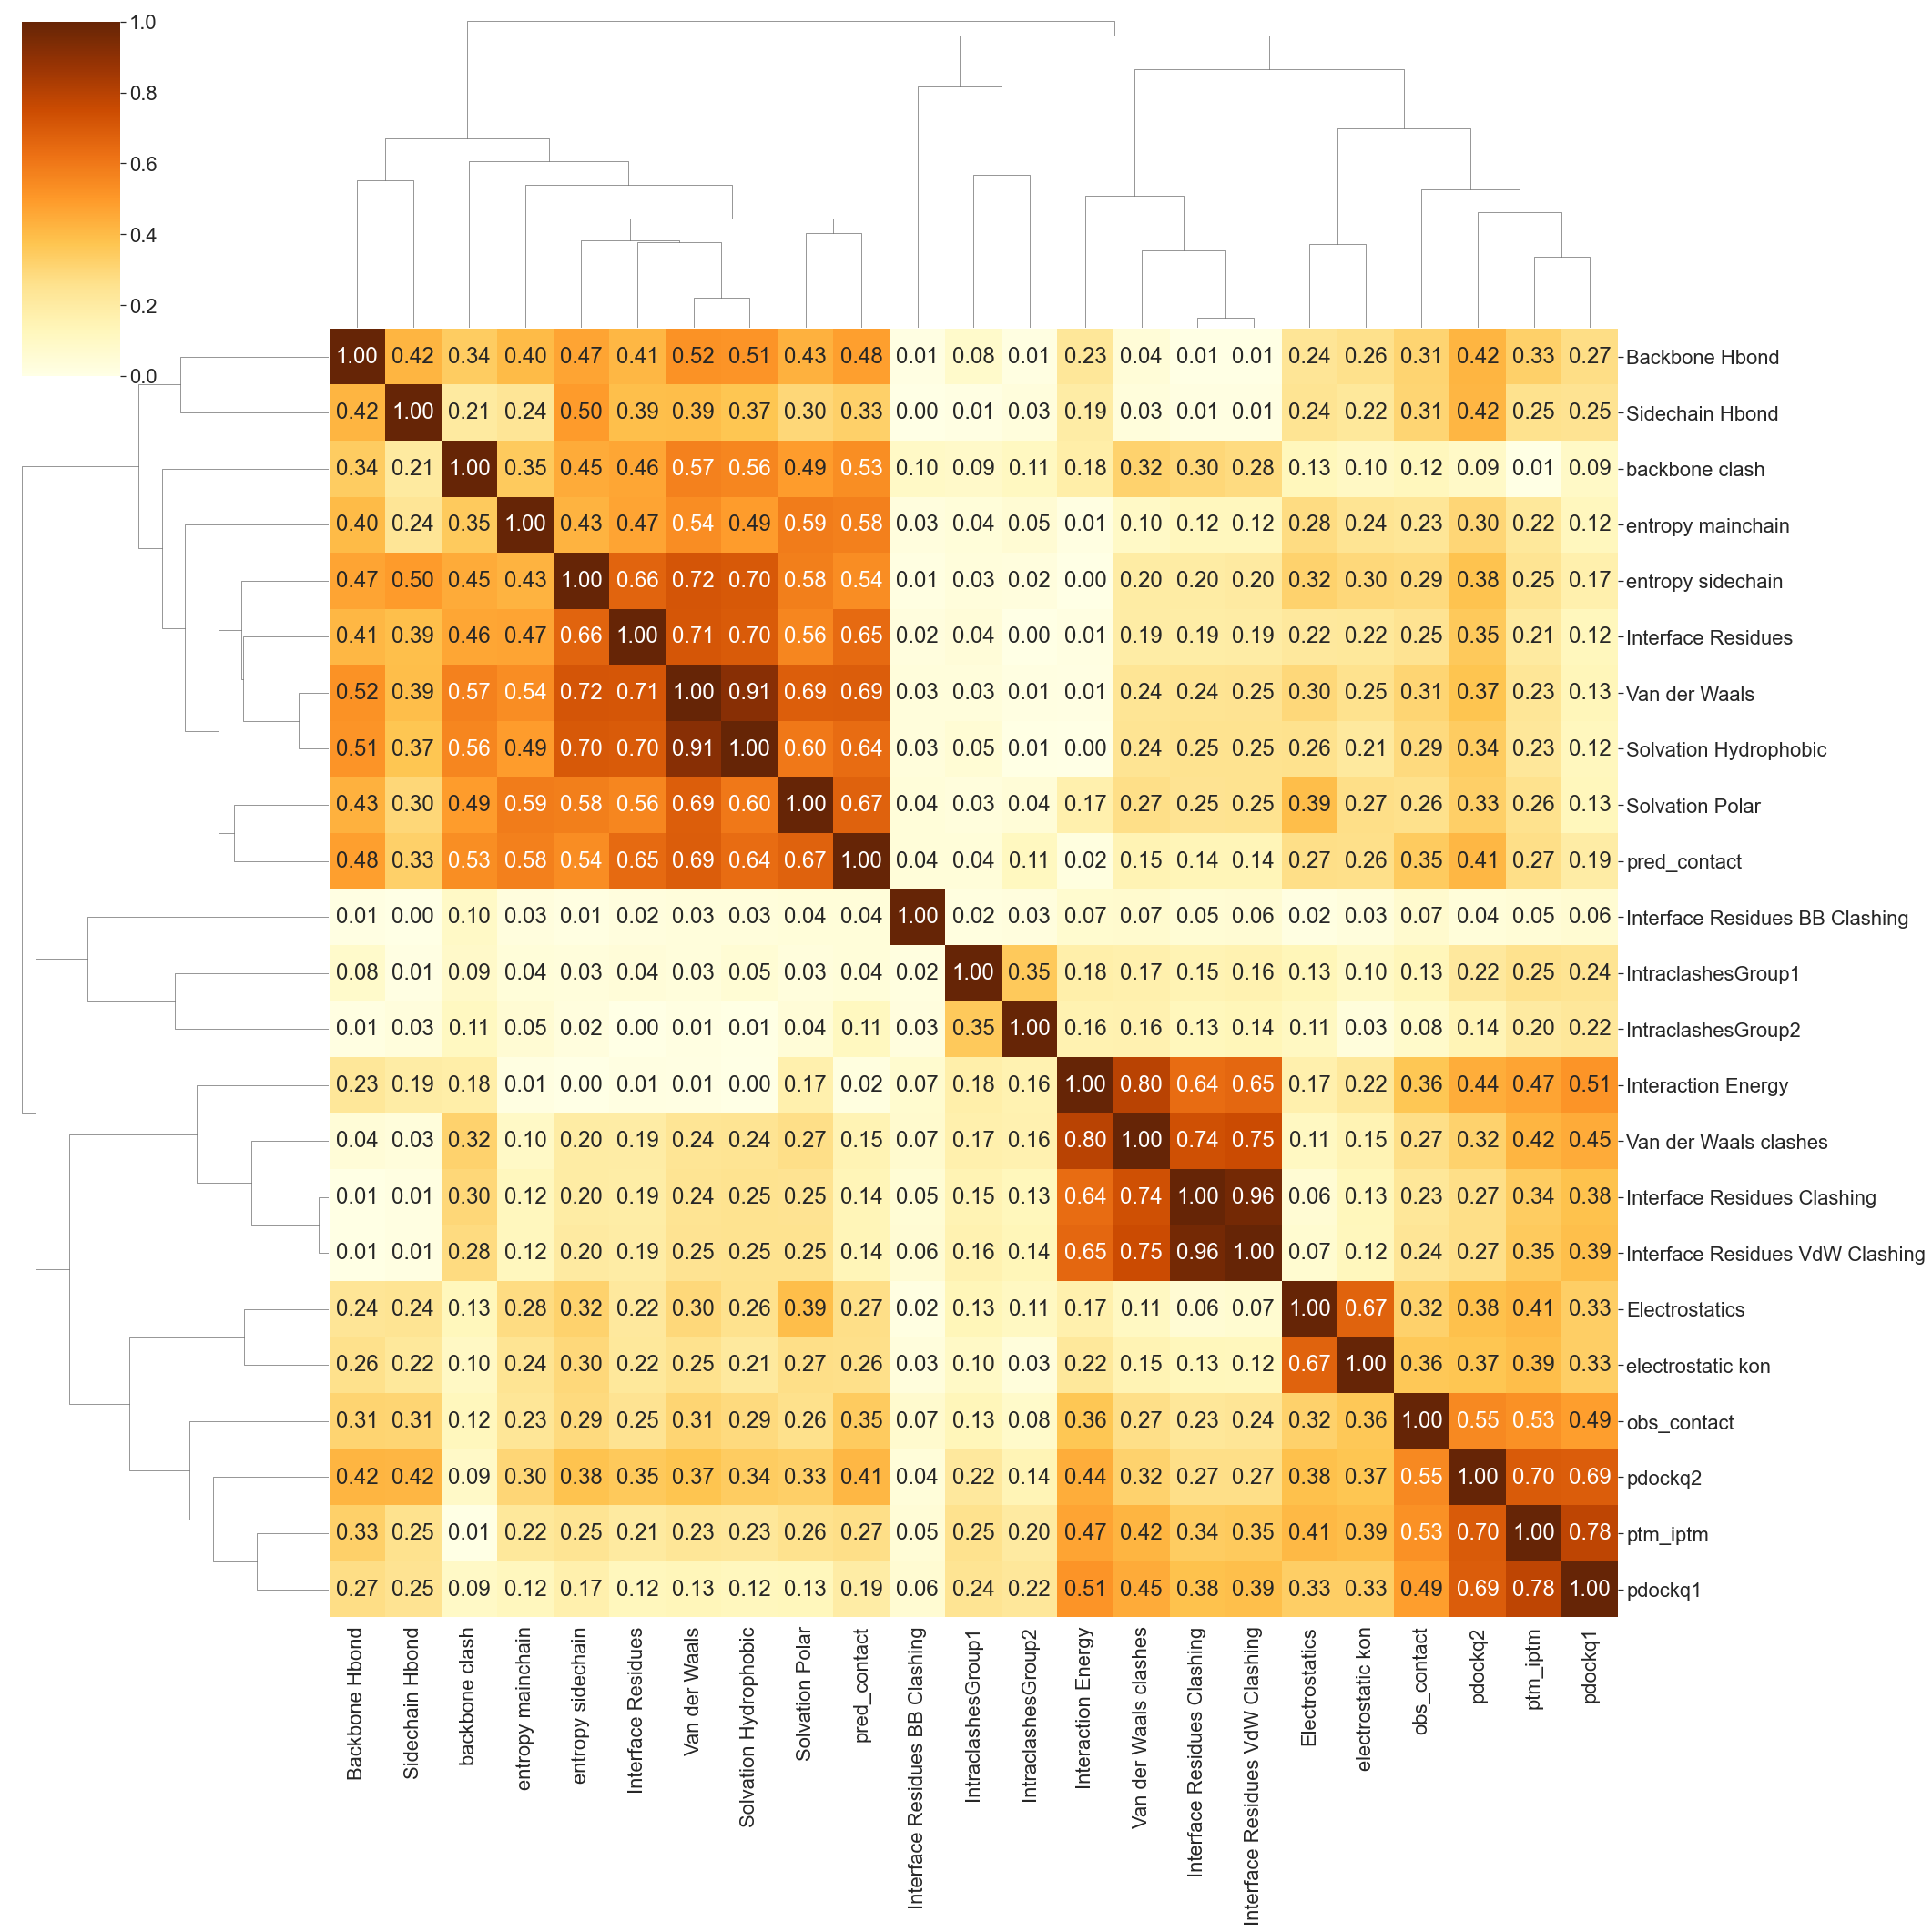

In [29]:
best_features="Interface Residues BB Clashing,IntraclashesGroup2,electrostatic kon,Interface Residues VdW Clashing,Interface Residues Clashing,Van der Waals clashes,Interaction Energy,ptm_iptm,pdockq2,pdockq1,obs_contact".split(',')
best_features
# Calculate the correlation matrix between the features
corr_matrix = np.abs(np.corrcoef(df2[selected_features], rowvar=False))
sns.set(font_scale=2)
annot = np.round(corr_matrix, decimals=2)
# Create a hierarchical clustering plot using Seaborn
sns.clustermap(corr_matrix, cmap="YlOrBr", xticklabels=df2[selected_features].columns, yticklabels=df2[selected_features].columns, annot=True,  fmt=".2f",figsize=(30, 30), vmin=0, vmax=1)

In [19]:
# Train and Test set
train_ids, test_ids = train_test_split(df2['pdb_id'].unique(), test_size=0.2, random_state=40)
X_train = df2[df2.pdb_id.isin(train_ids)].drop(['pdb_id','chain1','chain2','obs_contact', 'pair'], axis=1) # features
X_test = df2[df2.pdb_id.isin(test_ids)].drop(['pdb_id','chain1','chain2','obs_contact', 'pair'], axis=1) # features
y_train = df2[df2.pdb_id.isin(train_ids)]['obs_contact'] # Target variable
y_test = df2[df2.pdb_id.isin(test_ids)]['obs_contact'] # Target variable
X_test

,IntraclashesGroup1,IntraclashesGroup2,Interaction Energy,Backbone Hbond,Sidechain Hbond,Van der Waals,Electrostatics,Solvation Polar,Solvation Hydrophobic,Van der Waals clashes,...,ptm_iptm,pdockq2,pdockq1,backbone clash,Interface Residues,pred_contact,Interface Residues Clashing,electrostatic kon,Interface Residues BB Clashing,Interface Residues VdW Clashing
3,0.105769,0.548077,0.548077,0.605769,0.942308,0.538462,0.375000,0.442308,0.576923,0.490385,...,0.576923,0.375000,0.615385,0.519231,0.309179,0.278846,0.623762,0.548077,0.000000,0.628713
6,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.500000,0.000000,1.000000,0.500000,...,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
9,0.148148,0.185185,0.185185,0.666667,0.555556,0.925926,0.888889,0.111111,0.925926,0.185185,...,0.518519,0.333333,0.481481,0.111111,0.111111,0.148148,0.188679,0.888889,0.000000,0.188679
11,0.142857,0.095238,0.190476,0.904762,0.714286,0.714286,0.333333,0.190476,0.714286,0.142857,...,0.619048,0.142857,0.707317,0.047619,0.166667,0.071429,0.121951,0.238095,0.000000,0.150000
13,0.111111,0.444444,0.555556,0.666667,0.555556,0.888889,0.444444,0.111111,0.888889,0.222222,...,0.222222,0.222222,0.444444,0.111111,0.333333,0.222222,0.000000,0.777778,5.500000,0.000000
18,0.423077,0.586538,0.875000,0.336538,0.432692,0.317308,0.442308,0.596154,0.259615,0.875000,...,0.971154,0.942308,0.740385,0.307692,0.734300,0.634615,0.722772,0.788462,0.000000,0.742574
19,0.500000,0.500000,0.500000,1.000000,1.000000,0.500000,1.000000,0.000000,0.500000,0.000000,...,0.500000,0.500000,0.500000,0.500000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000
22,0.111111,0.777778,0.037037,0.370370,0.296296,0.888889,0.777778,0.037037,0.888889,0.148148,...,0.814815,0.592593,0.851852,0.000000,0.037037,0.111111,0.000000,0.666667,0.000000,0.000000
24,0.250000,0.557692,0.259615,0.980769,0.697115,0.990385,0.701923,0.009615,0.990385,0.115385,...,0.086538,0.019231,0.187500,0.019231,0.000000,0.019231,0.133663,0.644231,0.000000,0.133663
26,1.000000,1.000000,0.500000,0.000000,0.500000,1.000000,0.500000,0.000000,1.000000,0.500000,...,1.000000,0.500000,1.000000,0.000000,0.000000,0.500000,0.500000,0.500000,0.000000,0.500000


In [1]:
chain_count_dic={}
for pdb in df2['pdb_id'].unique():
    chain_count_dic[pdb]=len(set(df2[df2['pdb_id']==pdb]['chain1']).union(set(df2[df2['pdb_id']==pdb]['chain2'])))

train_dict = {key: value for key, value in chain_count_dic.items() if key in train_ids}
chain_counts = list(set(train_dict.values()))
counts = [list(train_dict.values()).count(count) for count in chain_counts]
plt.pie(counts, labels=chain_counts) #, autopct='%1.1f%%'
plt.title("train set")
plt.show()
test_dict = {key: value for key, value in chain_count_dic.items() if key in test_ids}
chain_counts = list(set(test_dict.values()))
counts = [list(test_dict.values()).count(count) for count in chain_counts]
plt.pie(counts, labels=chain_counts)
plt.title("test set")
plt.show()

NameError: name 'df2' is not defined

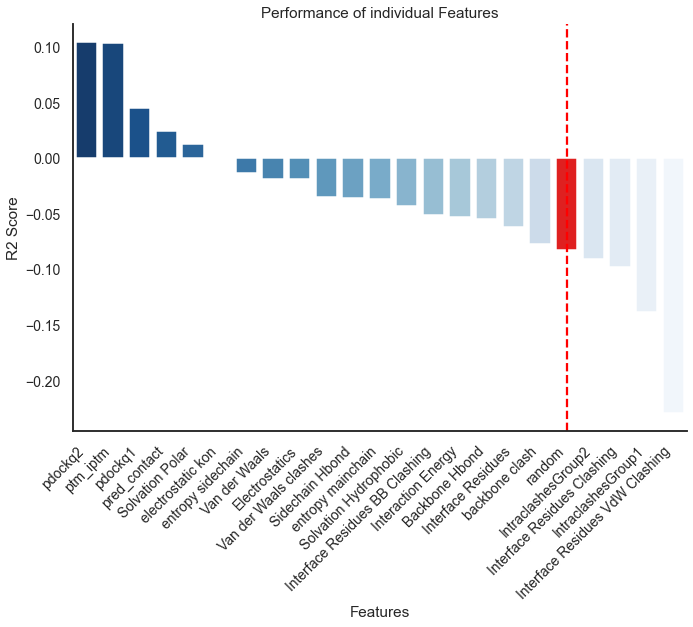

In [76]:
scores={}


random_train = np.random.randint(low=0, high=1, size=len(X_train)).reshape(-1,1)
random_test = np.random.randint(low=0, high=1, size=len(X_test)).reshape(-1,1)
rf_single = RandomForestRegressor(n_estimators= 100)
rf_single.fit(random_train, y_train)
y_pred = rf_single.predict(random_test)
scores['random']=r2_score(y_test, y_pred)

for feature in selected_features:
    if feature == 'obs_contact':
        continue
    i = list(X_train.columns).index(feature)
    X_tmp_train = np.array(X_train.iloc[:, i]).reshape(-1, 1)
    X_tmp_test = np.array(X_test.iloc[:, i]).reshape(-1, 1)
    rf_single = RandomForestRegressor(n_estimators=200)
    rf_single.fit(X_tmp_train, y_train)
    y_pred = rf_single.predict(X_tmp_test)
    
    scores[feature] = r2_score(y_test, y_pred)

    
    
    
# Convert the dictionary into a Pandas DataFrame and sort by value in descending order
df_tmp = pd.DataFrame(list(scores.items()), columns=["Features", "Values"]).sort_values(by="Values", ascending=False)

# Set the x-axis label and rotate the labels for better visibility
sns.set(rc={'figure.figsize':(11,7.5)})
sns.set_style('white')
sns.set_context('talk', font_scale=0.85)

# Set the color palette with red for "random" feature and blues_r for others
palette = {"random": "red"}
other_palette = sns.color_palette("Blues_r", len(df_tmp))
for i, feature in enumerate(df_tmp["Features"].tolist()):
    if feature != "random":
        palette[feature] = other_palette[i]

# Create the bar plot
ax = sns.barplot(x="Features", y="Values", data=df_tmp, order=df_tmp["Features"], palette=palette)
sns.despine()
plt.xticks(rotation=45, ha='right')
plt.ylabel("R2 Score")
plt.title('Performance of individual Features')

# Add a vertical dashed red line at the location of the "random" bar
random_index = np.where(df_tmp["Features"]=="random")[0][0]
ax.axvline(x=random_index, color="red", linestyle="--")

plt.show()

In [92]:
rf = RandomForestRegressor()
param_grid = {'n_estimators': [50, 100, 200],'max_depth': [10, 20, 30, None],'min_samples_split': [2, 5, 10],'min_samples_leaf': [1, 2, 4]}
#param_grid = {'n_estimators': [100],'max_depth': [None],'min_samples_split': [2],'min_samples_leaf': [2]}

# Perform grid search with 4 cross folds
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
print("Best n_estimators parameter: ", best_params)

# Create a Random Forest Regression model object
rf = RandomForestRegressor(**best_params)

# Train the model on the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model using Mean Squared Error (MSE)
print("MSE: ", mean_squared_error(y_test, y_pred))
print('R2 score: ', r2_score(y_test, y_pred))

Best n_estimators parameter:  {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
MSE:  0.10066021033801946
R2 score:  0.3219831363339325


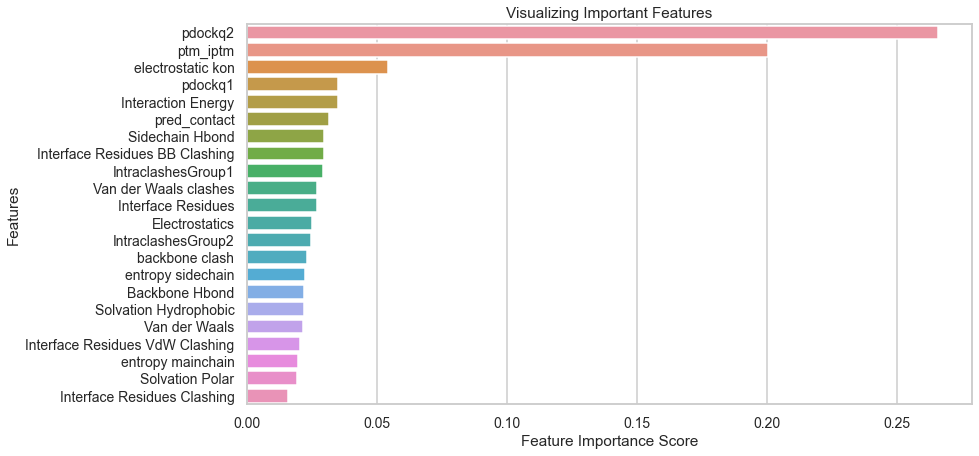

In [93]:
feature_importances = rf.feature_importances_
# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]
# Get names of features and their importance scores
feature_names = X_train.columns
feature_importances = feature_importances[indices]
# Plot feature importances
sns.set_style("whitegrid")
plt.figure(figsize=(13, 7))
sns.barplot(x=feature_importances, y=feature_names[indices])
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.show()

In [9]:
# Define the model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=len(X_train.columns)))
model.add(Dropout(0.3))  # Dropout rate to 0.3
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))  # Added an additional hidden layer with regularization
model.add(Dropout(0.6))
model.add(Dense(1))

# Compile the model
optimizer = Adam(learning_rate=0.001)  # Changed the optimizer to Adam with a lower learning rate
model.compile(optimizer=optimizer, loss='mae')

# Train the model
model.fit(X_train, y_train, epochs=20, verbose=0, batch_size=32)

# Evaluate the model
y_pred = model.predict(X_test)
print ('Model')
print('MSE: ', mean_squared_error(y_test, y_pred))
print('R2 score: ', r2_score(y_test, y_pred))

print ('Baseline')
# make a baseline model
y_mean = np.mean(y_train)  # y_train is the target variable in the training data
y_pred_baseline = np.full((len(X_test),), y_mean)
print('MSE: ', mean_squared_error(y_test, y_pred_baseline))
print('R2 score: ', r2_score(y_test, y_pred_baseline))

14/14 [==============================] - 0s 1ms/step
Model
MSE:  0.10192592314766333
R2 score:  0.3134576760093919
Baseline
MSE:  0.1608389845439279
R2 score:  -0.08336296426871481


In [15]:
pickle.dump(model, open("final_regression.sav", 'wb'))

Keras weights file (<HDF5 file "variables.h5" (mode r+)>) saving:
...layers\dense
......vars
.........0
.........1
...layers\dense_1
......vars
.........0
.........1
...layers\dense_2
......vars
.........0
.........1
...layers\dropout
......vars
...layers\dropout_1
......vars
...metrics\mean
......vars
.........0
.........1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.........2
.........3
.........4
.........5
.........6
.........7
.........8
.........9
...vars
Keras model archive saving:
File Name                                             Modified             Size
config.json                                    2023-06-05 17:18:10         2564
metadata.json                                  2023-06-05 17:18:10           64
variables.h5                                   2023-06-05 17:18:10       157960


In [10]:
y_test2 = pd.merge(y_test, df2[['pair','pdb_id']], left_index=True, right_index=True)
y_test2 = pd.merge(y_test2, df['obs_contact'], left_index=True, right_index=True)
y_test2['predictions'] = y_pred
#y_test2

for index,row in y_test2.iterrows():
    ID = row['pdb_id']
    maximum = max(df[df['pair'].str.contains(ID)]['obs_contact'])
    minimum = min(df[df['pair'].str.contains(ID)]['obs_contact'])
    if minimum==maximum: continue
    y_test2.loc[index,'obs_contact_x'] = y_test2.loc[index,'obs_contact_x']*(maximum-minimum)+minimum
    y_test2.loc[index,'predictions'] = y_test2.loc[index,'predictions']*(maximum-minimum)+minimum

#len([i for i in y_test2['obs_contact_x']==y_test2['obs_contact_y'] if i == False])
#y_test2  

[[163  59]
 [ 45 152]]
MCC_score:  0.504919635839039
              precision    recall  f1-score   support

           0       0.78      0.73      0.76       222
           1       0.72      0.77      0.75       197

    accuracy                           0.75       419
   macro avg       0.75      0.75      0.75       419
weighted avg       0.75      0.75      0.75       419



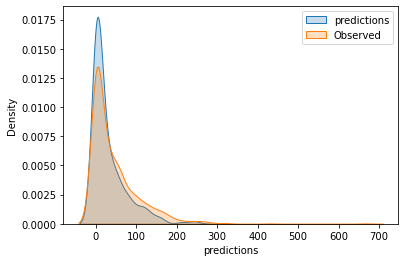

In [11]:
sns.kdeplot(y_test2['predictions'], shade=True, label='predictions')
sns.kdeplot(df['obs_contact'], shade=True, label='Observed')
#sns.kdeplot(y_test2['obs_contact_y'], shade=True, label='Observed')
plt.legend()

binary_true = np.where(y_test2['obs_contact_y'] > 10, 1, 0)
binary_pred = np.where(y_test2['predictions'] > 10, 1, 0)
print(confusion_matrix(binary_true,binary_pred))
print('MCC_score: ',matthews_corrcoef(binary_true,binary_pred))
print(classification_report(binary_true,binary_pred))

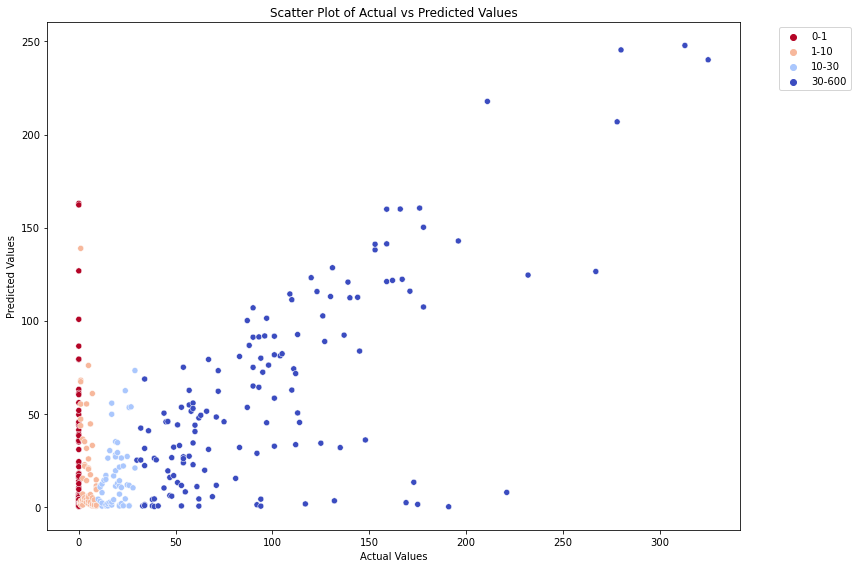

In [12]:
y_test2_sorted = y_test2.sort_values('obs_contact_y')
y_test2_new = y_test2_sorted.reset_index(drop=True)

ranges = [(0, 1), (1, 10), (10,30) ,(30, 600)]

# Generate a colormap index for each observation in y_test2_new['obs_contact_y']
obs_contact_colors = np.zeros_like(y_test2_new['obs_contact_y'], dtype=int)
for i, (start, end) in enumerate(ranges):
    obs_contact_colors[(start <= y_test2_new['obs_contact_y']) & (y_test2_new['obs_contact_y'] < end)] = i

# Create a dictionary to map colormap indices to value ranges
legend_labels = {i: f'{start}-{end}' for i, (start, end) in enumerate(ranges)}

# Plot the scatterplot with custom colors
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test2_new['obs_contact_y'], y=y_test2_new['predictions'], hue=obs_contact_colors, palette='coolwarm_r')

# Customize the legend labels
handles, _ = plt.gca().get_legend_handles_labels()
labels = [legend_labels[int(label)] for label in _]

# Move the legend outside the plot
plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Scatter Plot of Actual vs Predicted Values')
plt.tight_layout()  # Ensures the legend is not cut off
plt.show()

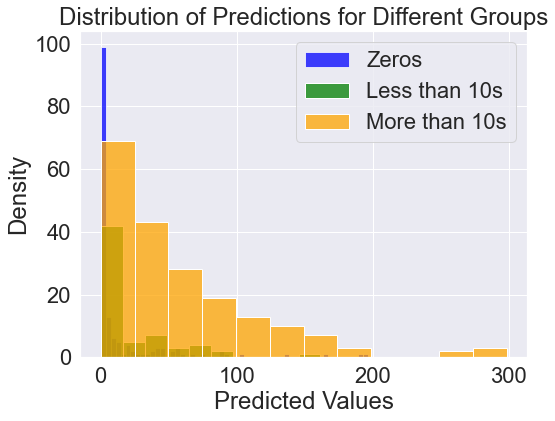

In [73]:
y_test2_sorted = y_test2.sort_values('obs_contact_y')
y_test2_new = y_test2_sorted.reset_index(drop=True)

predictions=y_test2_new['predictions']
# Filter the predictions for each group
predictions_zeros = predictions[y_test2_new.obs_contact_y == 0]
predictions_less_than_10s = predictions[(y_test2_new.obs_contact_y > 0) & (y_test2_new.obs_contact_y < 10)]
predictions_more_than_10s = predictions[y_test2_new.obs_contact_y > 10]

plt.figure(figsize=(8, 6))
# Create a single plot for all three groups
sns.histplot(predictions_zeros, label='Zeros' ,color='blue')
sns.histplot(predictions_less_than_10s, label='Less than 10s' ,color='green')
sns.histplot(predictions_more_than_10s, label='More than 10s' ,color='orange')

# Set the plot labels and title
plt.xlabel('Predicted Values')
plt.ylabel('Density')
plt.title('Distribution of Predictions for Different Groups')

# Display the legend
plt.legend()

# Show the plot
plt.show()

In [13]:
# Per Each PDB structure
unique_pdbs= list(set(y_test2['pair'].apply(lambda x: x.split('_')[0])))
len(unique_pdbs)
mcc_dic = {}
for pdb in unique_pdbs:
    pdb_df = y_test2[y_test2['pair'].str.contains(pdb)][['obs_contact_y','predictions']]
    pdb_true = np.where(pdb_df['obs_contact_y'] > 15, 1, 0)
    pdb_pred = np.where(pdb_df['predictions'] > 23, 1, 0)
    mcc_dic[pdb] = matthews_corrcoef(pdb_true,pdb_pred)
pd.set_option('display.max_rows', None)
y_test2[(y_test2['pdb_id']=='5LE5') & (y_test2['pair'].str.contains('_H'))].sort_values(by=['pair'])
sns.scatterplot(df=y_test2, x='obs_contact_y' ,y='predictions')

ValueError: Could not interpret value `obs_contact_y` for parameter `x`

<AxesSubplot:xlabel='pdockq1', ylabel='Interaction Energy'>

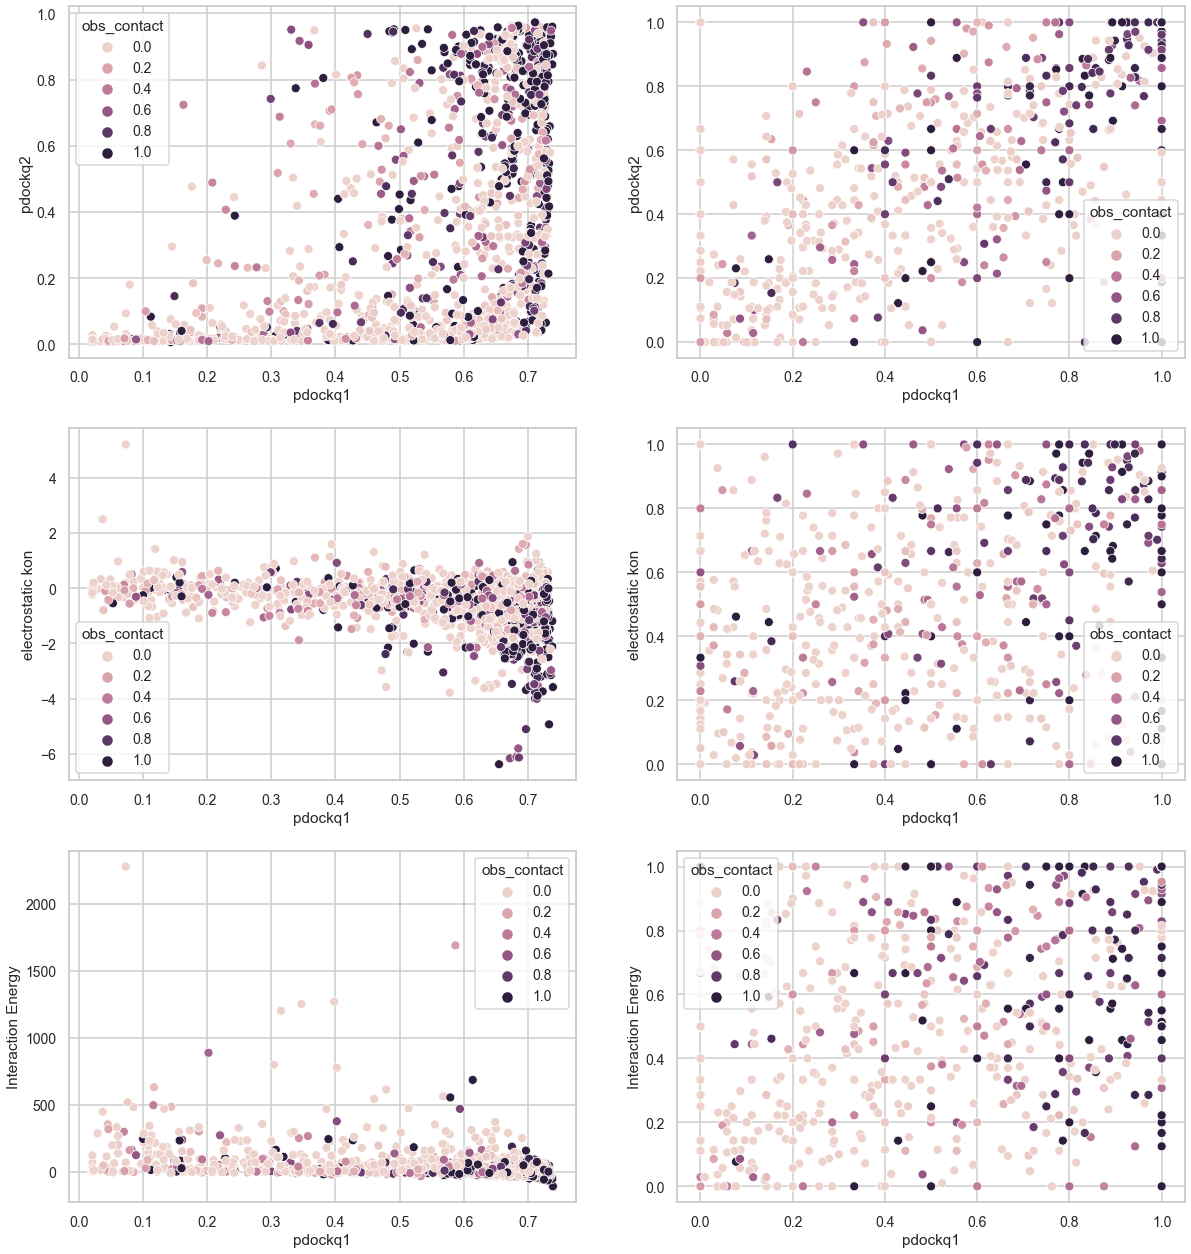

In [356]:
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 22))
sns.scatterplot(x=df['pdockq1'],y=df['pdockq2'],hue=df2['obs_contact'],ax=axes[0,0])
sns.scatterplot(x=df2['pdockq1'],y=df2['pdockq2'],hue=df2['obs_contact'],ax=axes[0,1])
sns.scatterplot(x=df['pdockq1'],y=df['electrostatic kon'],hue=df2['obs_contact'],ax=axes[1,0])
sns.scatterplot(x=df2['pdockq1'],y=df2['electrostatic kon'],hue=df2['obs_contact'],ax=axes[1,1])
sns.scatterplot(x=df['pdockq1'],y=df['Interaction Energy'],hue=df2['obs_contact'],ax=axes[2,0])
sns.scatterplot(x=df2['pdockq1'],y=df2['Interaction Energy'],hue=df2['obs_contact'],ax=axes[2,1])

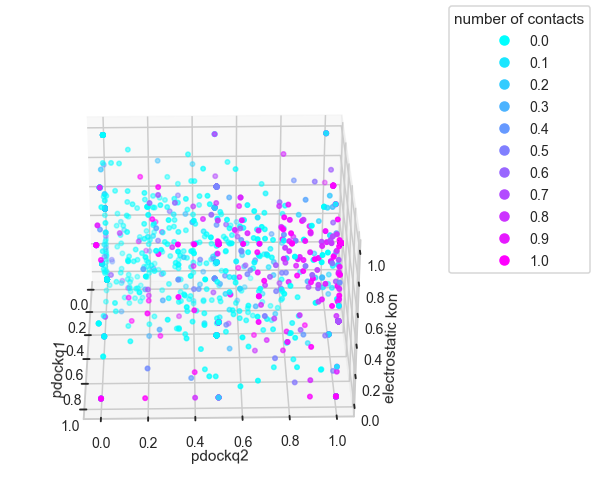

In [392]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import animation

# create a 3D scatterplot with x, y, and z mapped to sepal_length, sepal_width, and petal_length
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(df2["pdockq1"], df2["pdockq2"], df2["electrostatic kon"], c=df2["obs_contact"],cmap="cool")

# set the axis labels
ax.set_xlabel("pdockq1")
ax.set_ylabel("pdockq2")
ax.set_zlabel("electrostatic kon")
ax.view_init(elev=30, azim=120)
def animate(i):
    ax.view_init(elev=30, azim=i)
    return sc,

# create the animation
anim = animation.FuncAnimation(fig, animate, frames=360, interval=10)

# save the animation as a GIF using Pillow
anim.save('rotation2.gif', writer='pillow')

# show the plot
fig = plt.gcf()
handles, labels = sc.legend_elements()
fig.legend(handles, labels, title="number of contacts")
plt.show()